In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import re

In [2]:
# Global variables
dataDir = "ssec-aggregated/"
trainFile = dataDir+"train-combined-0.0.csv"
testFile = dataDir+"test-combined-0.0.csv"


In [3]:
KnownSentiments = ["Anger", "Anticipation", "Disgust", "Fear", "Joy", "Sadness", "Surprise", "Trust"]
dropAts=False
dropHashtags=False

eng_stopwords = set(stopwords.words('english'))

def tokenizePhrase(phrase):
    # Drop @-references used in social media texts.
    if dropAts:
        phrase = re.sub("@[^ ]*", "", phrase)
        
    # Drop hashtags
    if dropHashtags:
        phrase = re.sub("#[^ ]*", "", phrase)
        
    # Change non-alphabetic characters to spaces
    phrase = re.sub("[^A-Za-z]", " ", phrase).lower()
    
    # Tokenize phrase while removing stop words and dropping tokens that are not more than 1 char long.
    tokens = [w for w in word_tokenize(phrase) if w not in eng_stopwords and len(w)>1]
    
    return tokens
    
def parseSentence(sent):
    # The sentiment labels are encoded at the beginning of the line as tab-separated fields
    # Split the line by tabs so as to extract the labels and the text
    parts = sent.split("\t")
    
    if len(parts)<9:
        return ([], [])
    
    sentSents = parts[:8]
    
    # Match the sentiment labels with the known sentiments to extract a boolean vector 
    # encoding which sentiments are present.
    sentMap = [sentSents[i]==KnownSentiments[i] for i in range(0, len(sentSents))]

    
    # The actual text
    phrase = parts[8]
    
    tokens = tokenizePhrase(phrase)
    
    #return the sentiment map and the tokens extracted from the phrase
    return (sentMap, tokens)
    



In [4]:
# Bag of Words
class BoW:

    def fit(self, phraseTokens):
        for tok in phraseTokens:
            if tok not in self.vocabulary_:
                tok_ndx = len(self.vocabulary_)
                self.vocabulary_[tok]=tok_ndx
                self.index_[tok_ndx]=tok
                 
    def transform(self, phraseTokens):
        return [i for i in [self.vocabulary_.get(t, None) for t in phraseTokens] if i is not None]
    
    def fit_transform(self, phraseTokens):
        self.fit(phraseTokens)
        return self.transform(phraseTokens)
    
    vocabulary_=dict()
    index_=dict()


In [107]:
import math

# p(y|x) = p(x|y).p(y)
class NaiveBayes1:
    def __init__(self, classes):

        self.classes_=list(classes)
        print "Initialising NaiveBayes1 class with ", len(self.classes_), " classes..."
        self.globalCounts = np.zeros(1000) # pre-allocate 1000 tokens
        self.labelWordCounts = np.zeros((len(classes), 1000)) 
        self.pairwiseCounts = np.zeros((len(classes), len(classes), 1000))
        
        
    def update(self, labels, tokens):
        for w in tokens:
            toAdd=0
            # Does the word exist in our vocab?
            if w >= len(self.globalCounts):
                # No - extend the counts array to accomodate
                toAdd = int(math.ceil((w-len(self.globalCounts)+1) / 1000.0) * 1000)
                self.globalCounts = np.append(self.globalCounts, np.zeros(toAdd))

                
            self.globalCounts[w] += 1

            if toAdd>0:
                self.labelWordCounts = np.append(self.labelWordCounts, np.zeros((len(self.classes_),toAdd)), axis=1)
                self.pairwiseCounts = np.append(self.pairwiseCounts, np.zeros((len(self.classes_), len(self.classes_), toAdd)), axis=2) 
                
            for x in range(0, len(self.classes_)):

                if labels[x]:
                    self.labelWordCounts[x, w] += 1
                
                for y in range(0, len(self.classes_)):
                        
                    if (y>x): # avoid count split in two elements
                        if labels[x] and labels[y]:
                            self.pairwiseCounts[x,y, w]+=1
                            
        #self.recalc()
        
        
    def recalc(self):
        classProbs = np.array(self.labelWordCounts)

        # Laplace smoothed word probability by emotion - p(w|e) 
        # classes x tokens
        self.wordClassPosProbs = (1.0 * classProbs+1)/(sum(classProbs)+len(classProbs)) # p(x|y)

        # emotion probability - p(e) - element per class
        self.posClassProbs = np.sum(classProbs, axis=1)
        self.posClassProbs = (1.0*self.posClassProbs)/sum(self.posClassProbs) # p(y)
        
        classProbs = np.array(self.globalCounts) - classProbs
        
        # Laplace smoothed word probability by negative emotion - p(w|¬e)
        self.wordClassNegProbs = (1.0 * classProbs+1)/(sum(classProbs)+len(classProbs))

        # negative emotion probability - p(¬e) - element per class
        self.negClassProbs = np.sum(classProbs, axis=1)
        self.negClassProbs = (1.0*self.negClassProbs)/sum(self.negClassProbs) # p(¬y)
        
        # pairwise emotion conditional probability - p(e1 | e2) - class x class
        tempCounts = np.sum(self.pairwiseCounts, axis=2)
        self.pairwiseClassProbs = np.zeros((len(self.classes_), len(self.classes_)))
        for x in range(0, len(self.classes_)):
            for y in range(0, len(self.classes_)):
                if x==y:
                    self.pairwiseClassProbs[x, y]=1
                else:
                    if y > x: # p(x|y)
                        self.pairwiseClassProbs[x, y] = (1.0*tempCounts[x, y])/(sum(self.labelWordCounts[x]))
                    else: # p(y|x)
                        self.pairwiseClassProbs[x, y] = (1.0*tempCounts[y, x])/(sum(self.labelWordCounts[x]))
                        
    # set pairs of classes to correlate in results
    # { 1: 2 } -> add p(c1|c2) to prediction
    # { -1: 2 } -> add p(¬c1|c2) to prediction
    # { 1: -2 } -> add p(c1|¬c2) to prediction
    
    def setPariwiseDependencies(self, classPairs):
        self.classPairs = classPairs
        
    def classify(self, tokens):
        classPredictions = [False] * len(self.classes_)
        
        posClassProbs=[1.0]*len(classPredictions)
        negClassProbs=[1.0]*len(classPredictions)
        
        for tok in tokens:
            if tok < len(self.globalCounts):
                posClassProbs *= self.wordClassPosProbs[:, tok]
            
                negClassProbs *= self.wordClassNegProbs[:, tok]
                
        posClassProbs *= self.posClassProbs
        negClassProbs *= self.negClassProbs
        
        preds = posClassProbs>negClassProbs

        for key, value in self.classPairs.iteritems():
            if key > 0:
                if preds[key-1]:
                    if value > 0:
                        posClassProbs[key-1] *= self.pairwiseClassProbs[key-1, value-1]
                    else:
                        posClassProbs[key-1] *= (1-self.pairwiseClassProbs[key-1, (-value)-1]) # wrong!!
            else:
                if (not preds[(-key)-1]):
                    if value > 0:
                        negClassProbs[(-key)-1] *= (1-self.pairwiseClassProbs[(-key)-1, value-1])
                    else:
                        negClassProbs[(-key)-1] *= (1-self.pairwiseClassProbs[(-key)-1, (-value)-1]) # wrong!!
           
                
        preds = posClassProbs>negClassProbs
        
        return preds
                    
        
    classes_=list()
    globalCounts=np.array([]) # array of counts indexed by token id
    labelWordCounts=np.array([]) # array of classes_ rows x tokens columns
    pairwiseCounts=np.array([]) # array classes x classes x tokens
    classPairs=dict() # dict of emotion id -> emotion id

In [108]:
bow = BoW()
nb1 = NaiveBayes1(KnownSentiments)
i=0
for line in open(trainFile):
    #print i, line
    (classMap, tokens)=parseSentence(line)
    token_ndx = bow.fit_transform(tokens)
    
    nb1.update(classMap, token_ndx)
    
    i+=1
    
nb1.recalc()


Initialising NaiveBayes1 class with  8  classes...


In [113]:
nb1.setPariwiseDependencies({})
tallies = np.zeros((2, len(KnownSentiments)))

for line in open(testFile):
    (testClassMap, tokens) = parseSentence(line)
    if (tokens is None):
        continue
    tokens = bow.transform(tokens)
    preds = nb1.classify(tokens)
     
    hits = testClassMap==preds
    
    tallies[0,:] += hits
    tallies[1,:] += np.invert(hits)

origAccuracy = (1.0*tallies[0,:])/(tallies[0,:]+tallies[1,:])
print "Accuracy/class:"
print KnownSentiments
print origAccuracy

Accuracy/class:
['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
[ 0.66513292  0.62269939  0.63087935  0.62678937  0.63087935  0.56186094
  0.7305726   0.70654397]


Here we plot a heat map of pairwise class probability in order to see promising correlations between emotions.


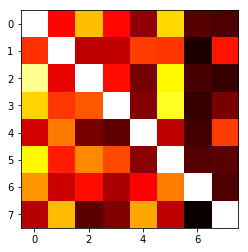

In [75]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(nb1.pairwiseClassProbs, cmap='hot', interpolation='nearest')
plt.show()
#print nb1.pairwiseClassProbs

We would like to improve our prediction of "Sadness" which is only slightly higher than 50%. According to the heat map,
p(Sadness|anger) is quite high (73% according to the model), therefore if we incorporate this correlation in our model,
we should get a better prediction for "Sadness". We also see positive correlations with p(anger|sadness), p(disgust|anger), p(disgust|sadness), p(fear|sadness) and p(sadness|anger). 

It turns out that including p(fear|sadness) results in a decrease in accuracy, however adding p(¬fear|surprise), improves it. Similarly adding p(¬anticipation|surprise) also gives a slight improvement.

In [153]:
nb1.setPariwiseDependencies({1:6, -2:7, 3:1, 3:6, -4:7, 6:1})

tallies = np.zeros((2, len(KnownSentiments)))

for line in open(testFile):
    (testClassMap, tokens) = parseSentence(line)
    if (tokens is None):
        continue
    tokens = bow.transform(tokens)
    preds = nb1.classify(tokens)
     
    hits = testClassMap==preds
    
    tallies[0,:] += hits
    tallies[1,:] += np.invert(hits)

modAccuracy = (1.0*tallies[0,:])/(tallies[0,:]+tallies[1,:])
print "Accuracy/class:"
print KnownSentiments
print modAccuracy

Accuracy/class:
['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
[ 0.66820041  0.62423313  0.6400818   0.62730061  0.63087935  0.56646217
  0.7305726   0.70654397]


In [154]:
delta = modAccuracy-origAccuracy
print delta

[ 0.00306748  0.00153374  0.00920245  0.00051125  0.          0.00460123
  0.          0.        ]


In [115]:
print tokens
print classMap
print bagOfWords.classes_
print bagOfWords.vocabulary_
print bagOfWords.index_
print bagOfWords.globalCounts
print bagOfWords.labelCounts
print bagOfWords.pairwiseCounts

['seals', 'legacy', 'doz', 'wins', 'The', 'agenda', 'STILL', 'Repeal', 'laws', 'Ban', 'Access']
[True, False, True, False, False, False, True, False]
['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
{'yellow': 3603, 'four': 5461, 'jihad': 1097, 'Olympics': 4459, 'hanging': 6206, 'Foundation': 205, 'Didnt': 6267, 'Ronald': 6601, 'Chemtrails': 3236, 'lord': 574, 'shielding': 5151, 'navigating': 6369, 'MISANDREEEEEEEEEEE': 4376, 'oceans': 2778, 'Secularism': 2256, 'figs': 1074, 'screaming': 4114, 'Less': 2430, 'Madhesi': 1400, 'solid': 6624, 'Does': 5428, 'Paul': 3056, 'ornamental': 4742, 'tired': 3745, 'Censorship': 4768, 'punning': 6091, 'Shocked': 6175, 'budget': 5792, 'Matthew': 588, 'second': 697, 'Shocker': 6724, 'loathing': 4212, 'captain': 4583, 'thunder': 2876, 'cooking': 4046, 'COMBINED': 5463, 'fossil': 757, 'misandry': 4578, 'succumb': 6486, 'reporter': 4180, 'error': 5652, 'brainwashed': 2376, 'reported': 3180, 'china': 5598, 'cult': 5242, '

In [70]:
int(classMap[0])

1

In [355]:
a = np.ones((3,3,4))
b = np.sum(a, axis=2)
print b
print len(b)

[[ 4.  4.  4.]
 [ 4.  4.  4.]
 [ 4.  4.  4.]]
3


In [353]:
c = (1.0*b)/sum(b)
print c

[[ 0.33333333  0.33333333  0.33333333]
 [ 0.33333333  0.33333333  0.33333333]
 [ 0.33333333  0.33333333  0.33333333]]
